- plt 전, 후 추가
- 이미지 변경 추가
- 배치사이즈 8로 변경
    - resnet에서 배치사이즈가 크면 그래픽 메모리 초과가 발생
- nomalize 삭제
- 모델 변경
- auc_ruc 추가
- 과적합 방지로 

In [1]:
import gdown
import torch
import torchvision
import os
from torchsummary import summary
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from tqdm import tqdm
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')
dir = './drive/MyDrive/iTStudy/Deep_Learning/miniProject/model_saved/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


- gpu 할당

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# 파라미터 설정

In [4]:
CFG = {
    'IMG_SIZE_W':244, #이미지 사이즈
    'IMG_SIZE_H':244,
    'EPOCHS':150, #에포크
    'LEARNING_RATE':0.0001, #학습률
    'BATCH_SIZE':32, #배치사이즈
    'SCHEDULER':6,
    'PATIENCE':14
}

# 데이터 적제

In [5]:
# ## google drive에서 압축된 dataset download
# url = 'https://drive.google.com/uc?id=1e_mqtQxew8bGOwtf1I2JvtlJIQ0CSUU8'
# fname = 'plant-pathology.zip'
# gdown.download(url, fname, quiet=False)
# !unzip plant-pathology.zip -d plant-pathology

파라미터 설정

## train.csv 전처리

- healthy = 0
- multiple_diseases = 1
- rust = 2
- scab = 3

In [6]:
df_train = pd.read_csv('./plant-pathology/train.csv')
df_train

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
...,...,...,...,...,...
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0


In [7]:
df_train.loc[df_train['healthy'] == 1, 'label'] = 0
df_train.loc[df_train['multiple_diseases'] == 1, 'label'] = 1
df_train.loc[df_train['rust'] == 1, 'label'] = 2
df_train.loc[df_train['scab'] == 1, 'label'] = 3

# 정수 형태로 변환
df_train['label'] = df_train['label'].apply(lambda x : int(x)) 

# 필요없는 columns 제거
df_train.drop(['healthy', 'multiple_diseases', 'rust', 'scab'], inplace=True, axis=1)

In [8]:
df_train.head()

,image_id,label
0,Train_0,3
1,Train_1,1
2,Train_2,0
3,Train_3,2
4,Train_4,0


# img path 가져오기

In [9]:
from glob import glob

def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    
    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, 'Train_*.jpg')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('_')[1].split('.')[0]))
        
    # get label
    #label_df = pd.read_csv(data_dir+'/train.csv')
    label_list.extend(df_train['label'])
                
    return img_path_list, label_list

def get_test_data(data_dir):
    img_path_list = []
    
    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, 'Test_*.jpg')))          # Test 데이터 분리
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('_')[1].split('.')[0]))  # Test 데이터 정렬. path의 마지막 Test_00.jpg

    
    return img_path_list

In [10]:
all_img_path, all_label = get_train_data('./plant-pathology/images')
test_img_path = get_test_data('./plant-pathology/images')

In [11]:
# img path에 5번째만 보여주기
for p, l in zip(all_img_path[:5], all_label[:5]):
    print(p, l)

./plant-pathology/images/Train_0.jpg 3
./plant-pathology/images/Train_1.jpg 1
./plant-pathology/images/Train_2.jpg 0
./plant-pathology/images/Train_3.jpg 2
./plant-pathology/images/Train_4.jpg 0


In [12]:
print(len(all_img_path), len(all_label), len(test_img_path))
print(all_label[:5])

1821 1821 1821
[3, 1, 0, 2, 0]


## 이미지 경로 -> 이미지로 변환

In [13]:
import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴
from PIL import Image

from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None): #필요한 변수들을 선언
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self, index): #index번째 data를 return
        img_path = self.img_path_list[index]
        # Get image data
        image = Image.open(img_path)
        if self.transforms is not None:
            image = self.transforms(image)

        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else:
            return image
    
    def __len__(self): #길이 return
        return len(self.img_path_list)

## 훈련 데이터셋 분리 (0.75):(0.25)

In [14]:
train_len = int(len(all_img_path)*0.75) # train 0.75
valid_len = int(len(all_img_path)*0.25)  # valid 0.25

# 데이터 분리
train_img_path = all_img_path[:train_len] 
train_label = all_label[:train_len]

# 정답 분리
valid_img_path = all_img_path[train_len:]
valid_label = all_label[train_len:]

In [15]:
print('train set 길이 : ', train_len)
print('vaildation set 길이 : ', valid_len)

train set 길이 :  1365
vaildation set 길이 :  455


- train 1365
- valid 455

# RGB 값의 mean과 std를 구한다.

- Tensor로만 변환시

In [16]:
train_ds = CustomDataset(train_img_path, train_label, train_mode=True, transforms=transforms.ToTensor())
val_ds = CustomDataset(valid_img_path, valid_label, train_mode=True, transforms=transforms.ToTensor())

In [17]:
train_ds_ = DataLoader(train_ds, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0) 
val_ds_ = DataLoader(val_ds, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0) 

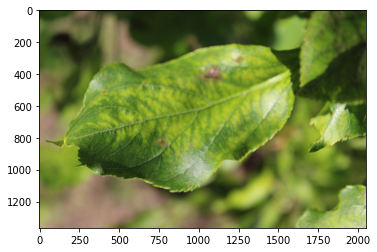

Label: 3


In [18]:
train_features, train_labels = train_ds[0] 

img = train_features
label = train_labels
plt.imshow(img.permute(1,2,0))
plt.show()
print(f"Label: {label}")

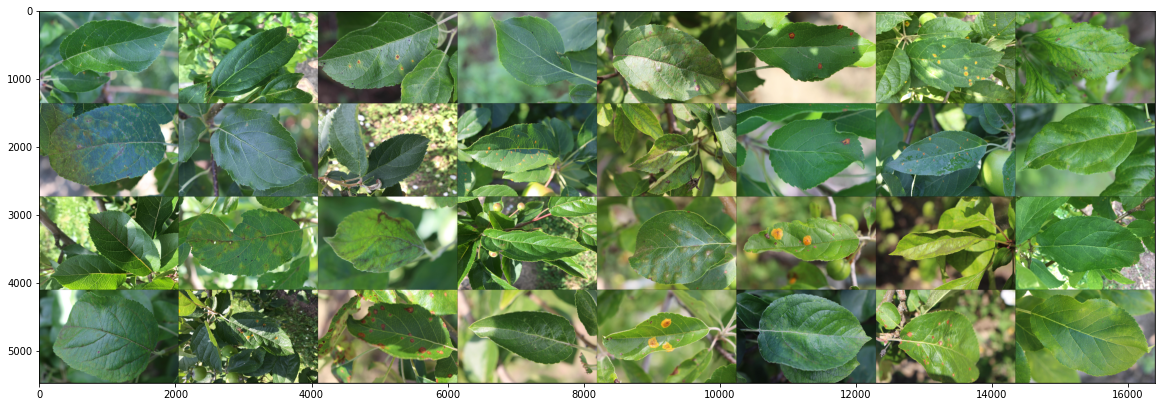

In [19]:
def imshow(img):         
    #img = img * 0.5 + 0.5 #unnormalize (normalize : (data - 0.5)/0.5))
    plt.figure(figsize=(20, 200))
    plt.imshow(img.permute(1, 2, 0))

dataiter = iter(train_ds_)
dataiter.next()
images, labels = dataiter.next() # 32개의 image, 32개의 label

imshow(torchvision.utils.make_grid(images, nrows=8))

In [20]:
print(images[0].shape) # C x H x W

torch.Size([3, 1365, 2048])


## 이미지 변환 준비
- Normalize를 위해
- 각 RGB의 mean과 std 를 구한다.

In [21]:
train_ds = CustomDataset(train_img_path, train_label, train_mode=True, transforms=transforms.ToTensor()) 

val_ds = CustomDataset(valid_img_path, valid_label, train_mode=True, transforms=transforms.ToTensor())

In [22]:
# train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_ds]
# train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_ds]

meanR = 0.40619999170303345
meanG = 0.5149000287055969
meanB = 0.31290000677108765
stdR = 0.043299999088048935
stdG = 0.042500000447034836
stdB = 0.03759999945759773

In [23]:
print(f'meanR : {meanR}, meanG : {meanG}, meanB : {meanB}')
print(f'stdR : {stdR}, stdG : {stdG}, train_stdB : {stdB}')

meanR : 0.40619999170303345, meanG : 0.5149000287055969, meanB : 0.31290000677108765
stdR : 0.043299999088048935, stdG : 0.042500000447034836, train_stdB : 0.03759999945759773


# 이미지 변경
- 사이즈 600 x 600
- 0.5 확률 좌우 대칭
- 0.5 확률 상하 대칭
- 0~180도 회전
- 확대
- 텐서로 변환

In [24]:
from torchvision.transforms.transforms import RandomRotation
train_transform = transforms.Compose([
                    transforms.ToTensor(), 
                    transforms.Resize([CFG['IMG_SIZE_W'], CFG['IMG_SIZE_H']]), 
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomVerticalFlip(p=0.5),
                    transforms.RandomRotation(degrees=(0, 180)),
                    transforms.CenterCrop((CFG['IMG_SIZE_W'], CFG['IMG_SIZE_H'])),
                    transforms.Normalize(mean=(meanR, meanG, meanB), std=(stdR, stdG, stdB))
                    ])

vali_transform = transforms.Compose([
                    transforms.ToTensor(), 
                    transforms.Resize([CFG['IMG_SIZE_W'], CFG['IMG_SIZE_H']]),
                    transforms.Normalize(mean=(meanR, meanG, meanB), std=(stdR, stdG, stdB))
                    ])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize([CFG['IMG_SIZE_W'], CFG['IMG_SIZE_H']]),
                                     transforms.Normalize(mean=(meanR, meanG, meanB), std=(stdR, stdG, stdB))
                                     ])

In [25]:
train_ds = CustomDataset(train_img_path, train_label, train_mode=True, transforms=train_transform) 

val_ds = CustomDataset(valid_img_path, valid_label, train_mode=True, transforms=vali_transform) 

test_ds = CustomDataset(test_img_path, valid_label, train_mode=False, transforms=test_transform) 

In [26]:
train_loader = DataLoader(train_ds, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0) 
vali_loader = DataLoader(val_ds, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


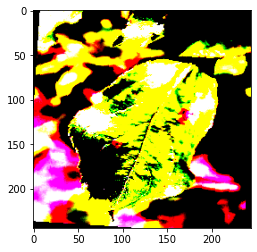

Label: 3


In [27]:
train_features, train_labels = train_ds[0] 

img = train_features
label = train_labels
plt.imshow(img.permute(1,2,0))
plt.show()
print(f"Label: {label}")

In [28]:
print(len(train_loader), len(vali_loader))
print(type(train_loader), type(vali_loader))

43 15
<class 'torch.utils.data.dataloader.DataLoader'> <class 'torch.utils.data.dataloader.DataLoader'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


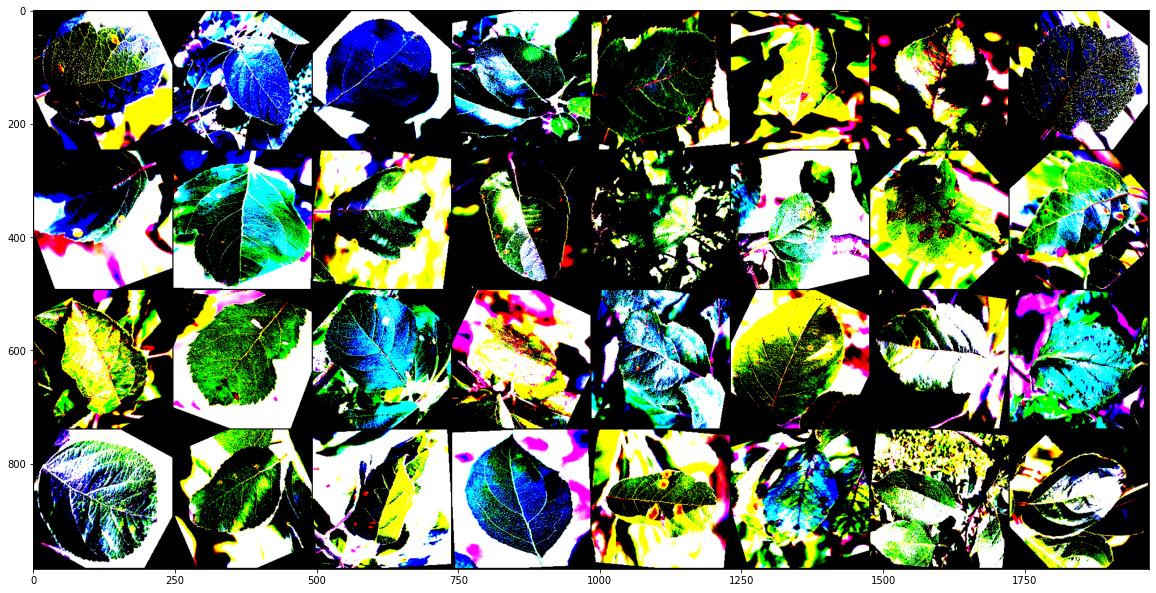

In [29]:
def imshow(img):         
    plt.figure(figsize=(20, 200))
    plt.imshow(img.permute(1, 2, 0))

dataiter = iter(train_loader)
images, labels = dataiter.next() 

imshow(torchvision.utils.make_grid(images, nrows=8))

# 모델 생성

In [30]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F


class Swish(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)


# SE Block
class SEBlock(nn.Module):
    def __init__(self, in_channels, r=4):
        super().__init__()

        self.squeeze = nn.AdaptiveAvgPool2d((1,1))
        self.excitation = nn.Sequential(
            nn.Linear(in_channels, in_channels * r),
            Swish(),
            nn.Linear(in_channels * r, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.squeeze(x)
        x = x.view(x.size(0), -1)
        x = self.excitation(x)
        x = x.view(x.size(0), x.size(1), 1, 1)
        return x


class MBConv(nn.Module):
    expand = 6
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, se_scale=4, p=0.5):
        super().__init__()
        # first MBConv is not using stochastic depth
        self.p = torch.tensor(p).float() if (in_channels == out_channels) else torch.tensor(1).float()

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, in_channels * MBConv.expand, 1, stride=stride, padding=0, bias=False),
            nn.BatchNorm2d(in_channels * MBConv.expand, momentum=0.99, eps=1e-3),
            Swish(),
            nn.Conv2d(in_channels * MBConv.expand, in_channels * MBConv.expand, kernel_size=kernel_size,
                      stride=1, padding=kernel_size//2, bias=False, groups=in_channels*MBConv.expand),
            nn.BatchNorm2d(in_channels * MBConv.expand, momentum=0.99, eps=1e-3),
            Swish()
        )

        self.se = SEBlock(in_channels * MBConv.expand, se_scale)

        self.project = nn.Sequential(
            nn.Conv2d(in_channels*MBConv.expand, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        )

        self.shortcut = (stride == 1) and (in_channels == out_channels)

    def forward(self, x):
        # stochastic depth
        if self.training:
            if not torch.bernoulli(self.p):
                return x

        x_shortcut = x
        x_residual = self.residual(x)
        x_se = self.se(x_residual)

        x = x_se * x_residual
        x = self.project(x)

        if self.shortcut:
            x= x_shortcut + x

        return x


class EfficientNet(nn.Module):
    def __init__(self, cfg, num_classes=4):
        super(EfficientNet, self).__init__()
        self.cfg = cfg
        self.conv1 = nn.Conv2d(3,
                               32,
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_channels=32)
        self.linear = nn.Linear(cfg['out_channels'][-1], num_classes)

    def _make_layers(self, in_channels):
        layers = []
        cfg = [self.cfg[k] for k in ['expansion', 'out_channels', 'num_blocks', 'kernel_size',
                                     'stride']]
        b = 0
        blocks = sum(self.cfg['num_blocks'])
        for expansion, out_channels, num_blocks, kernel_size, stride in zip(*cfg):
            strides = [stride] + [1] * (num_blocks - 1)
            for stride in strides:
                drop_rate = self.cfg['drop_connect_rate'] * b / blocks
                layers.append(
                    Block(in_channels,
                          out_channels,
                          kernel_size,
                          stride,
                          expansion,
                          se_ratio=0.25,
                          drop_rate=drop_rate))
                in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = swish(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        dropout_rate = self.cfg['dropout_rate']
        if self.training and dropout_rate > 0:
            out = F.dropout(out, p=dropout_rate)
        out = self.linear(out)
        return out


class SepConv(nn.Module):
    expand = 1
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, se_scale=4, p=0.5):
        super().__init__()
        # first SepConv is not using stochastic depth
        self.p = torch.tensor(p).float() if (in_channels == out_channels) else torch.tensor(1).float()

        self.residual = nn.Sequential(
            nn.Conv2d(in_channels * SepConv.expand, in_channels * SepConv.expand, kernel_size=kernel_size,
                      stride=1, padding=kernel_size//2, bias=False, groups=in_channels*SepConv.expand),
            nn.BatchNorm2d(in_channels * SepConv.expand, momentum=0.99, eps=1e-3),
            Swish()
        )

        self.se = SEBlock(in_channels * SepConv.expand, se_scale)

        self.project = nn.Sequential(
            nn.Conv2d(in_channels*SepConv.expand, out_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        )

        self.shortcut = (stride == 1) and (in_channels == out_channels)

    def forward(self, x):
        # stochastic depth
        if self.training:
            if not torch.bernoulli(self.p):
                return x

        x_shortcut = x
        x_residual = self.residual(x)
        x_se = self.se(x_residual)

        x = x_se * x_residual
        x = self.project(x)

        if self.shortcut:
            x= x_shortcut + x

        return x

class EfficientNet(nn.Module):
    def __init__(self, num_classes=10, width_coef=1., depth_coef=1., scale=1., dropout=0.2, se_scale=4, stochastic_depth=False, p=0.5):
        super().__init__()
        channels = [32, 16, 24, 40, 80, 112, 192, 320, 1280]
        repeats = [1, 2, 2, 3, 3, 4, 1]
        strides = [1, 2, 2, 2, 1, 2, 1]
        kernel_size = [3, 3, 5, 3, 5, 5, 3]
        depth = depth_coef
        width = width_coef

        channels = [int(x*width) for x in channels]
        repeats = [int(x*depth) for x in repeats]

        # stochastic depth
        if stochastic_depth:
            self.p = p
            self.step = (1 - 0.5) / (sum(repeats) - 1)
        else:
            self.p = 1
            self.step = 0


        # efficient net
        self.upsample = nn.Upsample(scale_factor=scale, mode='bilinear', align_corners=False)

        self.stage1 = nn.Sequential(
            nn.Conv2d(3, channels[0],3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(channels[0], momentum=0.99, eps=1e-3)
        )

        self.stage2 = self._make_Block(SepConv, repeats[0], channels[0], channels[1], kernel_size[0], strides[0], se_scale)

        self.stage3 = self._make_Block(MBConv, repeats[1], channels[1], channels[2], kernel_size[1], strides[1], se_scale)

        self.stage4 = self._make_Block(MBConv, repeats[2], channels[2], channels[3], kernel_size[2], strides[2], se_scale)

        self.stage5 = self._make_Block(MBConv, repeats[3], channels[3], channels[4], kernel_size[3], strides[3], se_scale)

        self.stage6 = self._make_Block(MBConv, repeats[4], channels[4], channels[5], kernel_size[4], strides[4], se_scale)

        self.stage7 = self._make_Block(MBConv, repeats[5], channels[5], channels[6], kernel_size[5], strides[5], se_scale)

        self.stage8 = self._make_Block(MBConv, repeats[6], channels[6], channels[7], kernel_size[6], strides[6], se_scale)

        self.stage9 = nn.Sequential(
            nn.Conv2d(channels[7], channels[8], 1, stride=1, bias=False),
            nn.BatchNorm2d(channels[8], momentum=0.99, eps=1e-3),
            Swish()
        ) 

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.dropout = nn.Dropout(p=dropout)
        self.linear = nn.Linear(channels[8], num_classes)

    def forward(self, x):
        x = self.upsample(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = self.stage6(x)
        x = self.stage7(x)
        x = self.stage8(x)
        x = self.stage9(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.linear(x)
        return x


    def _make_Block(self, block, repeats, in_channels, out_channels, kernel_size, stride, se_scale):
        strides = [stride] + [1] * (repeats - 1)
        layers = []
        for stride in strides:
            layers.append(block(in_channels, out_channels, kernel_size, stride, se_scale, self.p))
            in_channels = out_channels
            self.p -= self.step

        return nn.Sequential(*layers)


def efficientnet_b0(num_classes=4):
    return EfficientNet(num_classes=num_classes, width_coef=1.0, depth_coef=1.0, scale=1.0,dropout=0.2, se_scale=4)

def efficientnet_b1(num_classes=4):
    return EfficientNet(num_classes=num_classes, width_coef=1.0, depth_coef=1.1, scale=240/224, dropout=0.2, se_scale=4)

def efficientnet_b2(num_classes=4):
    return EfficientNet(num_classes=num_classes, width_coef=1.1, depth_coef=1.2, scale=260/224., dropout=0.3, se_scale=4)

def efficientnet_b3(num_classes=4):
    return EfficientNet(num_classes=num_classes, width_coef=1.2, depth_coef=1.4, scale=300/224, dropout=0.3, se_scale=4)

def efficientnet_b4(num_classes=4):
    return EfficientNet(num_classes=num_classes, width_coef=1.4, depth_coef=1.8, scale=380/224, dropout=0.4, se_scale=4)

def efficientnet_b5(num_classes=4):
    return EfficientNet(num_classes=num_classes, width_coef=1.6, depth_coef=2.2, scale=456/224, dropout=0.4, se_scale=4)

def efficientnet_b6(num_classes=4):
    return EfficientNet(num_classes=num_classes, width_coef=1.8, depth_coef=2.6, scale=528/224, dropout=0.5, se_scale=4)

def efficientnet_b7(num_classes=4):
    return EfficientNet(num_classes=num_classes, width_coef=2.0, depth_coef=3.1, scale=600/224, dropout=0.5, se_scale=4)

In [31]:
model = efficientnet_b0()
model.to(device) # model을 GPU로 보내기

EfficientNet(
  (upsample): Upsample(scale_factor=1.0, mode=bilinear)
  (stage1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
  )
  (stage2): Sequential(
    (0): SepConv(
      (residual): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): Swish(
          (sigmoid): Sigmoid()
        )
      )
      (se): SEBlock(
        (squeeze): AdaptiveAvgPool2d(output_size=(1, 1))
        (excitation): Sequential(
          (0): Linear(in_features=32, out_features=128, bias=True)
          (1): Swish(
            (sigmoid): Sigmoid()
          )
          (2): Linear(in_features=128, out_features=32, bias=True)
          (3): Sigmoid()
        )
      )
      (project): Sequential(
    

In [32]:
from torchsummary import summary
summary(model, (3, CFG['IMG_SIZE_W'], CFG['IMG_SIZE_H']))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
          Upsample-1          [-1, 3, 244, 244]               0
            Conv2d-2         [-1, 32, 122, 122]             864
       BatchNorm2d-3         [-1, 32, 122, 122]              64
            Conv2d-4         [-1, 32, 122, 122]             288
       BatchNorm2d-5         [-1, 32, 122, 122]              64
           Sigmoid-6         [-1, 32, 122, 122]               0
             Swish-7         [-1, 32, 122, 122]               0
 AdaptiveAvgPool2d-8             [-1, 32, 1, 1]               0
            Linear-9                  [-1, 128]           4,224
          Sigmoid-10                  [-1, 128]               0
            Swish-11                  [-1, 128]               0
           Linear-12                   [-1, 32]           4,128
          Sigmoid-13                   [-1, 32]               0
          SEBlock-14             [-1, 3

# 모델 훈련

In [33]:
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import roc_auc_score
writer = SummaryWriter()

def validation(model, testloader, criterion):
    test_accuracy = 0
    test_loss = 0
    true_onehot_list = []
    pred_list = []
    with torch.no_grad(): # 예측에는 gradient가 필요 없음
        for images, labels in testloader: # 1 iteration마다 배치 단위로 image와 label을 가져옴
            images, labels = images.to(device), labels.to(device) # data를 GPU로 보내기
            # Not Flatten!!!
            #images.resize_(images.shape[0], 784) # batch size x 784
            
            logits = model.forward(images) # 입력 : batch_size, 28, 28
            
            loss = criterion(logits, labels)
            test_loss += loss.item()

            probs = F.softmax(logits, dim=1)
            
            true_onehot = torch.eye(4)[labels].cpu().numpy()
            preds_ = torch.softmax(logits.cpu(), dim=1).numpy()

            pred_list.extend(preds_)
            true_onehot_list.extend(true_onehot)
            
            _, preds = torch.max(probs, 1) # preds = probs.max(dim=1)[1]
            correct = (preds == labels).sum()
            accuracy = correct / images.shape[0]
            test_accuracy += accuracy
        test_auc = roc_auc_score(true_onehot_list, pred_list)
    return test_loss, test_accuracy, test_auc     

In [34]:
learning_rate = CFG['LEARNING_RATE']
criterion = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=CFG['SCHEDULER'], factor=0.1, verbose=True)

In [35]:
# 모델 저장 폴더 생성
import os
try:
    os.mkdir('model_saved')
except:
    pass

In [36]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

vali_acc=[]
vali_loss=[]

def train(model, epochs, criterion, optimizer):
    global vali_acc, vali_loss
    steps = 0
 
    # 1 에폭(epoch)당 반복수
    #iter_per_epoch = len(trainset) / batch_size  
    iter_per_epoch = len(train_loader) 
    print_every = iter_per_epoch
    best_auc = 0
    valid_auc = 0

    # for Early stopping
    min_loss = 1000
    trigger = 0
    patience = CFG['PATIENCE']

    # learning
    valid_loss = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in tqdm(iter(train_loader)):
            steps += 1
            images, labels = images.to(device), labels.to(device)

            
            optimizer.zero_grad()

            # 1. Forward (Loss 얻게됨)
            output = model.forward(images)
            loss = criterion(output, labels)

            # 2. Backward (Gradient가 오차역전파로 구해짐)
            loss.backward()

            # 3. Gradient Descent (Model parameter update) :  W <- W-lr*Gradient
            optimizer.step() 

            train_loss += loss.item() # 1 epoch 당 누적된 로스
            
            if steps % print_every == 0 : 
                 # 배치 정규화, 드롭아웃 이 적용될 경우 model.forward 연산이 training 때와 다르므로 반드시 설정
                model.eval()
                valid_loss, valid_accuracy, valid_auc = validation(model, vali_loader, criterion)
                
                vali_acc.append(valid_accuracy/len(vali_loader))
                vali_loss.append(valid_loss/len(vali_loader))

                writer.add_scalar("Loss/train", train_loss/len(train_loader), epoch)
                writer.add_scalar("Loss/test", valid_loss/len(vali_loader), epoch)
                writer.add_scalars("Loss/train and valid",
                                { "train" : train_loss/len(train_loader),
                                    "test" : valid_loss/len(vali_loader) }, epoch)
                writer.add_scalar("test_roc_auc", valid_auc, epoch)

                print("Epoch : {}/{}...".format(epoch+1, epochs),
                    " Train Loss : {:.3f}".format(train_loss/len(train_loader) ),
                    " Valid Loss : {:.3f}".format(valid_loss/len(vali_loader)),
                    " Valid Accuracy : {:.3f}".format(valid_accuracy/len(vali_loader)),
                    " Valid AUC_ROC :  {:.3f}".format(valid_auc))
                
                # Early stopping Start 
                if valid_loss > min_loss: 
                    trigger +=1
                    print("trigger :", trigger)
                    if trigger > patience: 
                        print("Early Stopping!!!")
                        print("Train step is finished!!")
                        writer.flush()
                        writer.close() 
                        return
                else: 
                    min_loss = valid_loss
                    trigger = 0
                
                # Early stopping End
                train_loss = 0
                model.train()
            # Best model 저장
            if valid_auc >= best_auc:
                torch.save(model.state_dict(), dir+"best_model_efficientnet_b0.pth")
                best_auc = valid_auc
            

        # Learning Rate Scheduler 
        scheduler.step(valid_loss)
    writer.flush()
    writer.close()        

In [37]:
train(model, CFG['EPOCHS'], criterion, optimizer)

 98%|█████████▊| 42/43 [02:06<00:02,  2.81s/it]

Epoch : 1/150...  Train Loss : 40.367  Valid Loss : 38.872  Valid Accuracy : 0.394  Valid AUC_ROC :  0.590


 98%|█████████▊| 42/43 [02:01<00:02,  2.90s/it]

Epoch : 2/150...  Train Loss : 38.145  Valid Loss : 36.564  Valid Accuracy : 0.402  Valid AUC_ROC :  0.615


100%|██████████| 43/43 [02:25<00:00,  3.39s/it]


Epoch : 3/150...  Train Loss : 37.100  Valid Loss : 39.574  Valid Accuracy : 0.398  Valid AUC_ROC :  0.608
trigger : 1


 98%|█████████▊| 42/43 [01:25<00:02,  2.02s/it]

Epoch : 4/150...  Train Loss : 35.287  Valid Loss : 34.558  Valid Accuracy : 0.506  Valid AUC_ROC :  0.690


 98%|█████████▊| 42/43 [02:03<00:02,  2.83s/it]

Epoch : 5/150...  Train Loss : 32.939  Valid Loss : 32.834  Valid Accuracy : 0.533  Valid AUC_ROC :  0.719


 98%|█████████▊| 42/43 [01:55<00:02,  2.72s/it]

Epoch : 6/150...  Train Loss : 31.366  Valid Loss : 30.976  Valid Accuracy : 0.569  Valid AUC_ROC :  0.741


100%|██████████| 43/43 [02:30<00:00,  3.50s/it]


Epoch : 7/150...  Train Loss : 28.479  Valid Loss : 29.877  Valid Accuracy : 0.573  Valid AUC_ROC :  0.726


 98%|█████████▊| 42/43 [01:21<00:01,  1.95s/it]

Epoch : 8/150...  Train Loss : 28.117  Valid Loss : 31.741  Valid Accuracy : 0.571  Valid AUC_ROC :  0.777
trigger : 1


100%|██████████| 43/43 [02:22<00:00,  3.32s/it]


Epoch : 9/150...  Train Loss : 26.173  Valid Loss : 28.845  Valid Accuracy : 0.604  Valid AUC_ROC :  0.767


 98%|█████████▊| 42/43 [01:22<00:01,  1.96s/it]

Epoch : 10/150...  Train Loss : 25.069  Valid Loss : 31.914  Valid Accuracy : 0.575  Valid AUC_ROC :  0.790
trigger : 1


 98%|█████████▊| 42/43 [02:04<00:02,  2.88s/it]

Epoch : 11/150...  Train Loss : 23.846  Valid Loss : 26.693  Valid Accuracy : 0.660  Valid AUC_ROC :  0.826


100%|██████████| 43/43 [02:36<00:00,  3.63s/it]


Epoch : 12/150...  Train Loss : 22.364  Valid Loss : 26.541  Valid Accuracy : 0.650  Valid AUC_ROC :  0.816


100%|██████████| 43/43 [01:50<00:00,  2.56s/it]


Epoch : 13/150...  Train Loss : 21.327  Valid Loss : 25.689  Valid Accuracy : 0.681  Valid AUC_ROC :  0.814


 98%|█████████▊| 42/43 [01:24<00:02,  2.02s/it]

Epoch : 14/150...  Train Loss : 20.205  Valid Loss : 22.415  Valid Accuracy : 0.710  Valid AUC_ROC :  0.857


 98%|█████████▊| 42/43 [02:09<00:03,  3.29s/it]

Epoch : 15/150...  Train Loss : 20.266  Valid Loss : 20.357  Valid Accuracy : 0.744  Valid AUC_ROC :  0.858


100%|██████████| 43/43 [02:39<00:00,  3.71s/it]


Epoch : 16/150...  Train Loss : 18.336  Valid Loss : 21.965  Valid Accuracy : 0.715  Valid AUC_ROC :  0.827
trigger : 1


 98%|█████████▊| 42/43 [01:24<00:02,  2.00s/it]

Epoch : 17/150...  Train Loss : 18.569  Valid Loss : 21.838  Valid Accuracy : 0.752  Valid AUC_ROC :  0.863
trigger : 2


 98%|█████████▊| 42/43 [02:06<00:03,  3.16s/it]

Epoch : 18/150...  Train Loss : 17.539  Valid Loss : 18.570  Valid Accuracy : 0.773  Valid AUC_ROC :  0.887


100%|██████████| 43/43 [02:33<00:00,  3.57s/it]


Epoch : 19/150...  Train Loss : 17.013  Valid Loss : 20.780  Valid Accuracy : 0.760  Valid AUC_ROC :  0.853
trigger : 1


100%|██████████| 43/43 [01:50<00:00,  2.57s/it]


Epoch : 20/150...  Train Loss : 16.474  Valid Loss : 21.000  Valid Accuracy : 0.758  Valid AUC_ROC :  0.846
trigger : 2


100%|██████████| 43/43 [01:50<00:00,  2.57s/it]


Epoch : 21/150...  Train Loss : 16.940  Valid Loss : 25.910  Valid Accuracy : 0.746  Valid AUC_ROC :  0.863
trigger : 3


 98%|█████████▊| 42/43 [01:24<00:02,  2.02s/it]

Epoch : 22/150...  Train Loss : 15.153  Valid Loss : 17.833  Valid Accuracy : 0.792  Valid AUC_ROC :  0.901


100%|██████████| 43/43 [02:35<00:00,  3.62s/it]


Epoch : 23/150...  Train Loss : 15.239  Valid Loss : 25.693  Valid Accuracy : 0.744  Valid AUC_ROC :  0.871
trigger : 1


100%|██████████| 43/43 [01:50<00:00,  2.57s/it]


Epoch : 24/150...  Train Loss : 14.879  Valid Loss : 19.238  Valid Accuracy : 0.773  Valid AUC_ROC :  0.887
trigger : 2


100%|██████████| 43/43 [01:48<00:00,  2.53s/it]


Epoch : 25/150...  Train Loss : 14.290  Valid Loss : 20.197  Valid Accuracy : 0.777  Valid AUC_ROC :  0.879
trigger : 3


 98%|█████████▊| 42/43 [01:21<00:01,  1.94s/it]

Epoch : 26/150...  Train Loss : 14.121  Valid Loss : 16.158  Valid Accuracy : 0.785  Valid AUC_ROC :  0.912


100%|██████████| 43/43 [02:29<00:00,  3.47s/it]


Epoch : 27/150...  Train Loss : 12.717  Valid Loss : 19.193  Valid Accuracy : 0.806  Valid AUC_ROC :  0.875
trigger : 1


100%|██████████| 43/43 [01:52<00:00,  2.62s/it]


Epoch : 28/150...  Train Loss : 12.514  Valid Loss : 17.399  Valid Accuracy : 0.815  Valid AUC_ROC :  0.896
trigger : 2


100%|██████████| 43/43 [01:50<00:00,  2.57s/it]


Epoch : 29/150...  Train Loss : 12.974  Valid Loss : 15.235  Valid Accuracy : 0.808  Valid AUC_ROC :  0.910


100%|██████████| 43/43 [01:49<00:00,  2.55s/it]


Epoch : 30/150...  Train Loss : 13.056  Valid Loss : 18.180  Valid Accuracy : 0.779  Valid AUC_ROC :  0.904
trigger : 1


100%|██████████| 43/43 [01:49<00:00,  2.55s/it]


Epoch : 31/150...  Train Loss : 12.348  Valid Loss : 17.456  Valid Accuracy : 0.804  Valid AUC_ROC :  0.873
trigger : 2


 98%|█████████▊| 42/43 [01:24<00:01,  2.00s/it]

Epoch : 32/150...  Train Loss : 11.127  Valid Loss : 17.714  Valid Accuracy : 0.794  Valid AUC_ROC :  0.918
trigger : 3


100%|██████████| 43/43 [02:31<00:00,  3.53s/it]


Epoch : 33/150...  Train Loss : 11.659  Valid Loss : 15.016  Valid Accuracy : 0.833  Valid AUC_ROC :  0.908


100%|██████████| 43/43 [01:51<00:00,  2.58s/it]


Epoch : 34/150...  Train Loss : 11.514  Valid Loss : 17.123  Valid Accuracy : 0.821  Valid AUC_ROC :  0.890
trigger : 1


 98%|█████████▊| 42/43 [01:24<00:02,  2.03s/it]

Epoch : 35/150...  Train Loss : 10.436  Valid Loss : 15.223  Valid Accuracy : 0.835  Valid AUC_ROC :  0.918
trigger : 2


100%|██████████| 43/43 [02:35<00:00,  3.62s/it]


Epoch : 36/150...  Train Loss : 10.669  Valid Loss : 14.792  Valid Accuracy : 0.815  Valid AUC_ROC :  0.914


100%|██████████| 43/43 [01:50<00:00,  2.58s/it]


Epoch : 37/150...  Train Loss : 10.369  Valid Loss : 14.350  Valid Accuracy : 0.842  Valid AUC_ROC :  0.916


 98%|█████████▊| 42/43 [01:25<00:02,  2.03s/it]

Epoch : 38/150...  Train Loss : 9.491  Valid Loss : 14.688  Valid Accuracy : 0.825  Valid AUC_ROC :  0.931
trigger : 1


100%|██████████| 43/43 [02:33<00:00,  3.57s/it]


Epoch : 39/150...  Train Loss : 10.309  Valid Loss : 19.078  Valid Accuracy : 0.792  Valid AUC_ROC :  0.893
trigger : 2


100%|██████████| 43/43 [01:49<00:00,  2.55s/it]


Epoch : 40/150...  Train Loss : 9.363  Valid Loss : 17.822  Valid Accuracy : 0.813  Valid AUC_ROC :  0.924
trigger : 3


100%|██████████| 43/43 [01:49<00:00,  2.55s/it]


Epoch : 41/150...  Train Loss : 9.552  Valid Loss : 14.253  Valid Accuracy : 0.842  Valid AUC_ROC :  0.924


100%|██████████| 43/43 [01:50<00:00,  2.56s/it]


Epoch : 42/150...  Train Loss : 8.927  Valid Loss : 15.147  Valid Accuracy : 0.838  Valid AUC_ROC :  0.928
trigger : 1


100%|██████████| 43/43 [01:50<00:00,  2.58s/it]


Epoch : 43/150...  Train Loss : 8.464  Valid Loss : 17.105  Valid Accuracy : 0.806  Valid AUC_ROC :  0.913
trigger : 2


100%|██████████| 43/43 [01:51<00:00,  2.60s/it]


Epoch : 44/150...  Train Loss : 8.957  Valid Loss : 14.868  Valid Accuracy : 0.835  Valid AUC_ROC :  0.927
trigger : 3


100%|██████████| 43/43 [01:52<00:00,  2.61s/it]


Epoch : 45/150...  Train Loss : 9.116  Valid Loss : 14.755  Valid Accuracy : 0.831  Valid AUC_ROC :  0.920
trigger : 4


100%|██████████| 43/43 [01:51<00:00,  2.59s/it]


Epoch : 46/150...  Train Loss : 8.551  Valid Loss : 14.614  Valid Accuracy : 0.825  Valid AUC_ROC :  0.929
trigger : 5


100%|██████████| 43/43 [01:51<00:00,  2.59s/it]


Epoch : 47/150...  Train Loss : 8.321  Valid Loss : 16.187  Valid Accuracy : 0.842  Valid AUC_ROC :  0.904
trigger : 6


100%|██████████| 43/43 [01:51<00:00,  2.60s/it]


Epoch : 48/150...  Train Loss : 9.470  Valid Loss : 12.769  Valid Accuracy : 0.850  Valid AUC_ROC :  0.928


 98%|█████████▊| 42/43 [01:25<00:02,  2.06s/it]

Epoch : 49/150...  Train Loss : 8.496  Valid Loss : 15.627  Valid Accuracy : 0.827  Valid AUC_ROC :  0.939
trigger : 1


100%|██████████| 43/43 [02:36<00:00,  3.64s/it]


Epoch : 50/150...  Train Loss : 8.231  Valid Loss : 13.303  Valid Accuracy : 0.844  Valid AUC_ROC :  0.934
trigger : 2


100%|██████████| 43/43 [01:53<00:00,  2.65s/it]


Epoch : 51/150...  Train Loss : 8.004  Valid Loss : 14.404  Valid Accuracy : 0.852  Valid AUC_ROC :  0.926
trigger : 3


100%|██████████| 43/43 [01:51<00:00,  2.60s/it]


Epoch : 52/150...  Train Loss : 7.847  Valid Loss : 21.147  Valid Accuracy : 0.823  Valid AUC_ROC :  0.914
trigger : 4


100%|██████████| 43/43 [01:49<00:00,  2.55s/it]


Epoch : 53/150...  Train Loss : 7.835  Valid Loss : 13.077  Valid Accuracy : 0.865  Valid AUC_ROC :  0.938
trigger : 5


100%|██████████| 43/43 [01:47<00:00,  2.50s/it]


Epoch : 54/150...  Train Loss : 7.463  Valid Loss : 13.972  Valid Accuracy : 0.848  Valid AUC_ROC :  0.926
trigger : 6


100%|██████████| 43/43 [01:47<00:00,  2.49s/it]


Epoch : 55/150...  Train Loss : 7.816  Valid Loss : 13.616  Valid Accuracy : 0.863  Valid AUC_ROC :  0.938
trigger : 7
Epoch 00055: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 43/43 [01:48<00:00,  2.51s/it]


Epoch : 56/150...  Train Loss : 6.360  Valid Loss : 14.468  Valid Accuracy : 0.854  Valid AUC_ROC :  0.933
trigger : 8


 98%|█████████▊| 42/43 [01:25<00:01,  1.97s/it]

Epoch : 57/150...  Train Loss : 6.910  Valid Loss : 13.415  Valid Accuracy : 0.856  Valid AUC_ROC :  0.942
trigger : 9


100%|██████████| 43/43 [02:34<00:00,  3.59s/it]


Epoch : 58/150...  Train Loss : 6.132  Valid Loss : 15.137  Valid Accuracy : 0.844  Valid AUC_ROC :  0.929
trigger : 10


 98%|█████████▊| 42/43 [01:24<00:02,  2.01s/it]

Epoch : 59/150...  Train Loss : 5.688  Valid Loss : 14.863  Valid Accuracy : 0.840  Valid AUC_ROC :  0.946
trigger : 11


100%|██████████| 43/43 [02:30<00:00,  3.50s/it]


Epoch : 60/150...  Train Loss : 5.970  Valid Loss : 13.767  Valid Accuracy : 0.856  Valid AUC_ROC :  0.935
trigger : 12


100%|██████████| 43/43 [01:51<00:00,  2.58s/it]


Epoch : 61/150...  Train Loss : 5.757  Valid Loss : 16.878  Valid Accuracy : 0.844  Valid AUC_ROC :  0.939
trigger : 13


100%|██████████| 43/43 [01:50<00:00,  2.57s/it]


Epoch : 62/150...  Train Loss : 5.922  Valid Loss : 16.051  Valid Accuracy : 0.850  Valid AUC_ROC :  0.927
trigger : 14
Epoch 00062: reducing learning rate of group 0 to 1.0000e-06.


 98%|█████████▊| 42/43 [01:50<00:02,  2.63s/it]

Epoch : 63/150...  Train Loss : 5.075  Valid Loss : 15.815  Valid Accuracy : 0.850  Valid AUC_ROC :  0.946
trigger : 15
Early Stopping!!!
Train step is finished!!


# 모델 평가

In [38]:
def evaluate(model, testloader):
    test_accuracy = 0
    test_loss = 0
    true_onehot_list = []
    pred_list = []
    model.eval()
    with torch.no_grad(): # 예측에는 gradient가 필요 없음
        for images, labels in testloader: # 1 iteration마다 배치 단위로 image와 label을 가져옴
            images, labels = images.to(device), labels.to(device)
            # not Flatten!
            #images.resize_(images.shape[0], 784) # batch size x 784
            logits = model.forward(images) # 입력 : batch * height * width
            
            loss = criterion(logits, labels)
            test_loss += loss.item()

            true_onehot = torch.eye(4)[labels].cpu().numpy()
            preds_ = torch.softmax(logits.cpu(), dim=1).numpy()

            pred_list.extend(preds_)
            true_onehot_list.extend(true_onehot)

            probs = F.softmax(logits, dim=1)
            _, preds = torch.max(probs, 1) # preds = probs.max(dim=1)[1]

            correct = (preds == labels).sum()
            accuracy = correct / images.shape[0]
            test_accuracy += accuracy.item()

        test_auc = roc_auc_score(true_onehot_list, pred_list)
    print("Test Loss : ", test_loss/len(testloader))
    print("Accuracy : ", test_accuracy/len(testloader))
    print("AUC_ROC : ", test_auc)
    return pred_list

In [39]:
# 마지막 학습결과를 저장 후 나중에 사용하기 원할 때
torch.save(model.state_dict(), dir+"last_checkpoint_EfficientNetB0.pth")
state_dict = torch.load(dir+"last_checkpoint_EfficientNetB0.pth") 
last_model = resnet101() # 이미 model에 마지막 학습결과가 있으나 last_model로 다시 불러옴
last_model.to(device)
last_model.load_state_dict(state_dict) # model과 parameter를 매치 시키는 작업
test_preds=evaluate(last_model, test_loader)

NameError: ignored

In [ ]:
# Test Accuracy 기준으로 가장 높을때의 모델 파라미터가 저장되어 있음
state_dict = torch.load(dir+"best_model_efficientnet_b0.pth") 
best_model = EfficientNetB0()
best_model.to(device)
best_model.load_state_dict(state_dict)
evaluate(best_model, test_loader)